Find exposures of a single night

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [4]:
ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62,
                  }

fringe_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
image_dir = '/global/project/projectdirs/cosmo/staging/'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'

In [5]:
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdraoff', 'ccddecoff']
ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
# ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z'
ccd = ccd[mask]
print(len(ccd))

1148265


0


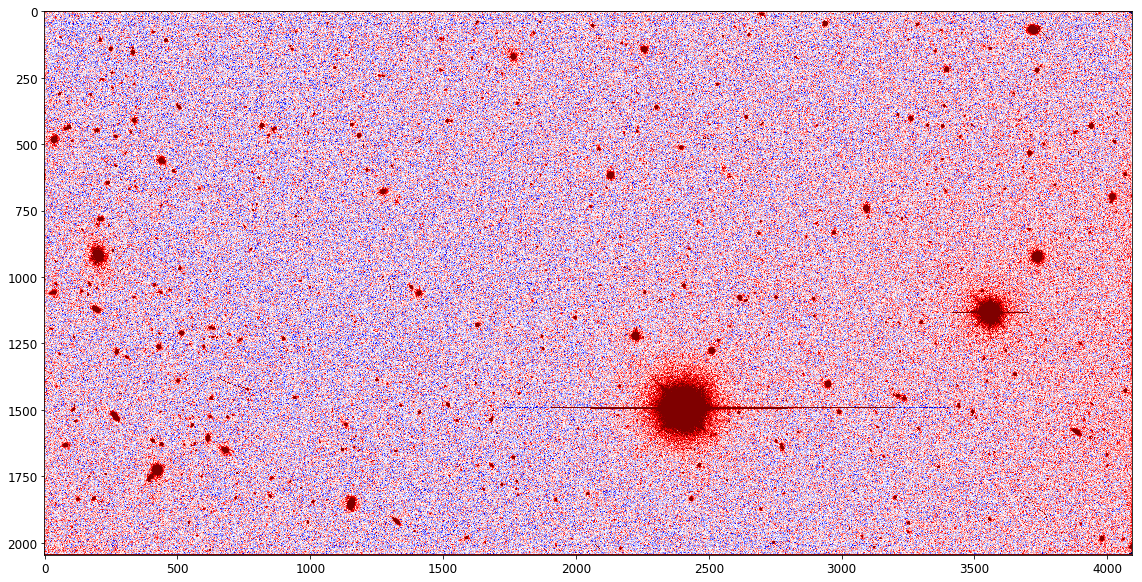

2033.511


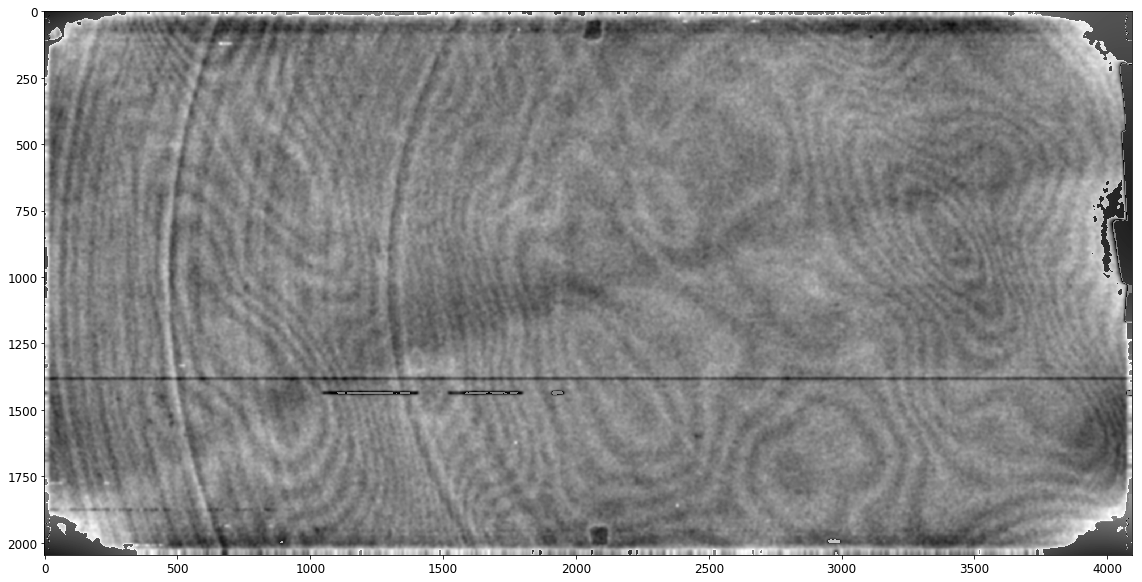

In [6]:
####################### Load CCD image #######################
ccd_index = 0
# ccd_index = len(ccd)//2
print(ccd_index)

img_fn = os.path.join(image_dir, ccd['image_filename'][ccd_index]).strip()
hdulist = fits.open(img_fn)
w = wcs.WCS(hdulist[ccd['image_hdu'][ccd_index]].header)
img = hdulist[ccd['image_hdu'][ccd_index]].data
frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']

# naive sky estimation
mask = (img<np.percentile(img.flatten(), 85))
sky = np.median(img[mask].flatten())
vrange = 2*(sky - np.percentile(img.flatten(), 0.5))

# # pad the edges with zeros to match the fringe image dimension
# img = np.pad(img, ((1, 1), (1, 1)), mode='constant', constant_values=0)

plt.figure(figsize=(20, 10))
plt.imshow(img.T, cmap='seismic', vmin=sky-vrange, vmax=sky+vrange, origin='upper')
plt.show()

####################### Load fringe image #######################
print(frgscale)
ccdnum = str(ccdnamenumdict[ccd[ccd_index]['ccdname'].strip()]).zfill(2)
fringe_path = os.path.join(fringe_dir, 'DES17B_20180103_908c062-z-{}_frg.fits'.format(ccdnum))
# fringe_path = os.path.join(fringe_dir, (hdulist[ccd['image_hdu'][ccd_index]].header)['FRINGE']+'.fits')
fringe = fits.getdata(fringe_path)
# remove the edge pixels
fringe = fringe[1:4095, 1:2047]

plt.figure(figsize=(20, 10))
plt.imshow(fringe.T, cmap='gray', origin='upper')
plt.show()

####################### Load brick list #######################
bricks = Table.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-bricks.fits.gz')

In [11]:
# here x and y are not numpy indices, but they are the x-y values in the DECam CCD schematics
pix_x_grid, pix_y_grid = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
pix_x = pix_x_grid.flatten()
pix_y = pix_y_grid.flatten()
# plt.figure(figsize=(20, 10))
# plt.imshow(pix_x_grid.T, cmap='gray', origin='upper')
# plt.show()
# plt.figure(figsize=(20, 10))
# plt.imshow(pix_y_grid.T, cmap='gray', origin='upper')
# plt.show()

In [12]:
pix_ra, pix_dec = w.wcs_pix2world(pix_x, pix_y, 0)
pix_ra = pix_ra + ccd['ccdraoff'][ccd_index] / 3600.
pix_dec = pix_dec + ccd['ccddecoff'][ccd_index] / 3600.
# plt.figure(figsize=(20, 10))
# plt.imshow(pix_ra.T, cmap='gray', origin='upper')
# plt.show()
# plt.figure(figsize=(20, 10))
# plt.imshow(pix_dec.T, cmap='gray', origin='upper')
# plt.show()

4


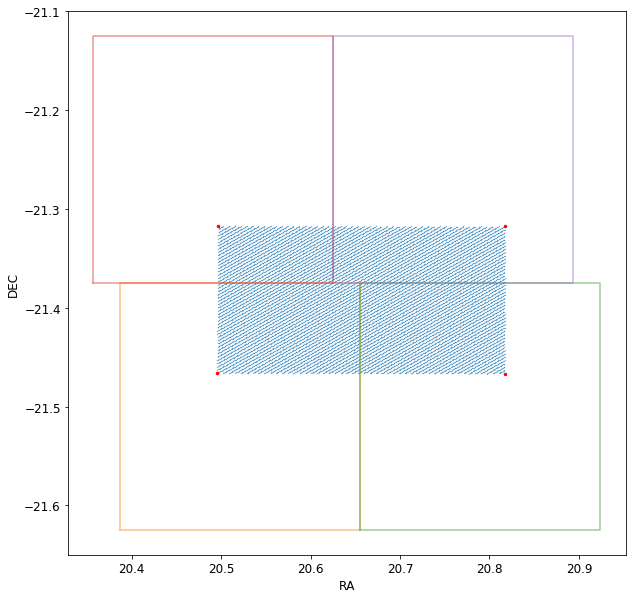

In [16]:
ccd_corners = [[pix_ra.min(), pix_dec.min()], 
               [pix_ra.min(), pix_dec.max()], 
               [pix_ra.max(), pix_dec.min()], 
               [pix_ra.max(), pix_dec.max()]]
ccd_corners = np.array(ccd_corners)

mask = np.zeros(len(bricks), dtype=bool)
for index in range(len(ccd_corners)):
    mask |= (bricks['RA1']<ccd_corners[index, 0]) & (bricks['RA2']>ccd_corners[index, 0]) \
     & (bricks['DEC1']<ccd_corners[index, 1]) & (bricks['DEC2']>ccd_corners[index, 1])
print(np.sum(mask))

brick_idx = np.where(mask)[0]

points = w.wcs_pix2world([[0,0], [img.shape[1], img.shape[0]], [0, img.shape[0]], [img.shape[1], 0]], 0)
plt.figure(figsize=(10, 10))
plt.plot(pix_ra[::500], pix_dec[::500], '.', ms=0.5)
for index in brick_idx:
    ra_plot = [bricks['RA1'][index], bricks['RA1'][index], bricks['RA2'][index], bricks['RA2'][index], bricks['RA1'][index]]
    dec_plot = [bricks['DEC1'][index], bricks['DEC2'][index], bricks['DEC2'][index], bricks['DEC1'][index], bricks['DEC1'][index]]
    plt.plot(ra_plot, dec_plot, alpha=0.5)
plt.plot(points[:, 0], points[:, 1], '.', ms=5, color='r')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [17]:
img_mask = np.zeros_like(img, dtype=bool)

for brick_index in brick_idx:
    brickname = bricks['BRICKNAME'][brick_index]
    blobs = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/metrics/{}/blobs-{}.fits.gz'.format(brickname[:3], brickname))
    maskbits = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/coadd/{}/{}/legacysurvey-{}-maskbits.fits.fz'.format(brickname[:3], brickname, brickname))
    mask_bad = (blobs!=-1) # -1 means no source detected
    mask_bad |= (maskbits&2**0>0) # brick_primary
    mask_bad |= (maskbits&2**1>0) # BRIGHT star
    mask_bad |= (maskbits&2**2>0) | (maskbits&2**3>0) | (maskbits&2**4>0)  # saturation
    mask_bad |= (maskbits&2**5>0) | (maskbits&2**6>0) | (maskbits&2**7>0)  # allmask
    mask_bad |= (maskbits&2**11>0) | (maskbits&2**12>0) | (maskbits&2**13>0) # MEDIUM, GALAXY, CLUSTER
    mask_good = ~mask_bad
    
    blob_hdu = fits.open('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/metrics/{}/blobs-{}.fits.gz'.format(brickname[:3], brickname))
    w_blob = wcs.WCS(blob_hdu[0].header)
    coadd_x, coadd_y = w_blob.wcs_world2pix(pix_ra, pix_dec, 0)
    coadd_x, coadd_y = np.round(coadd_x).astype(int), np.round(coadd_y).astype(int)
    mask = (coadd_x>=0) & (coadd_x<blobs.shape[0]) & (coadd_y>=0) & (coadd_y<blobs.shape[0])
    img_mask[pix_y[mask], pix_x[mask]] |= mask_good[coadd_y[mask], coadd_x[mask]]

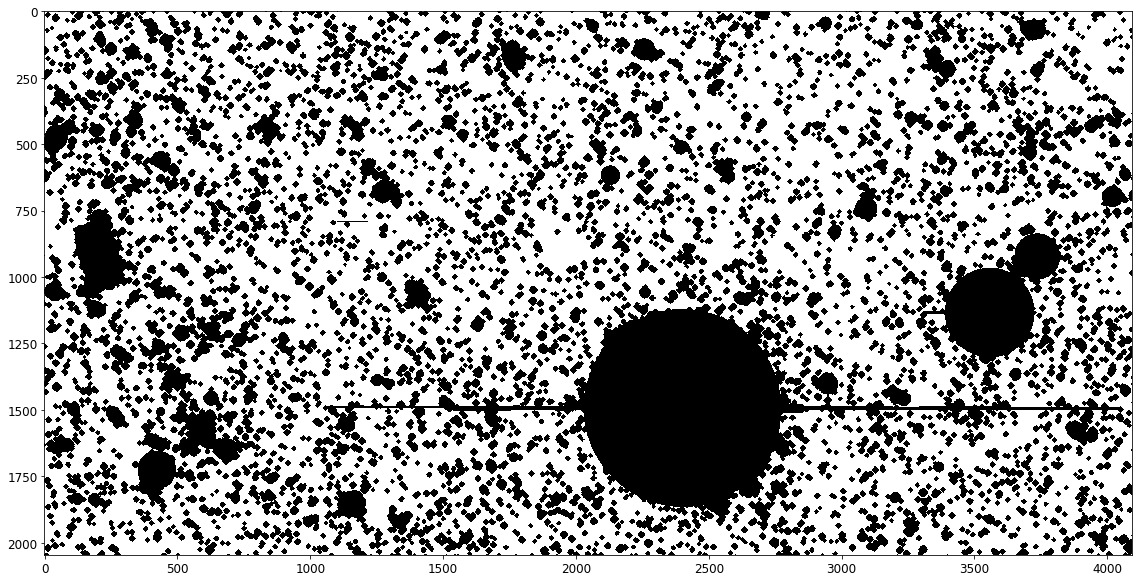

In [18]:
plt.figure(figsize=(20, 10))
plt.imshow(img_mask.T, cmap='gray', origin='upper')
plt.show()

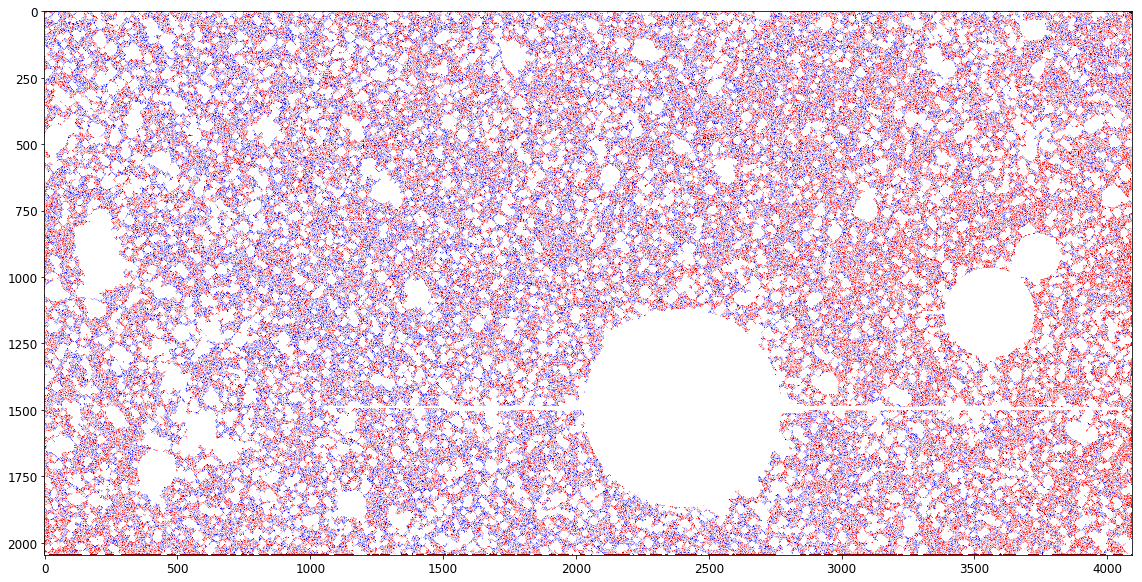

In [19]:
img_masked = img.copy()
img_masked[~img_mask] = np.nan
plt.figure(figsize=(20, 10))
plt.imshow(img_masked.T, cmap='seismic', vmin=sky-vrange, vmax=sky+vrange, origin='upper')
plt.show()

In [250]:
# # Reconstruct CCD-sized image from coadd
# img_coadd = np.zeros_like(img)
# for brick_index in brick_idx:
#     brickname = bricks['BRICKNAME'][brick_index]
#     maskbits = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/coadd/{}/{}/legacysurvey-{}-maskbits.fits.fz'.format(brickname[:3], brickname, brickname))
#     coadd = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/coadd/{}/{}/legacysurvey-{}-image-z.fits.fz'.format(brickname[:3], brickname, brickname))
#     mask_good = ~(maskbits&2**0>0) # brick_primary    
#     blob_hdu = fits.open('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/metrics/{}/blobs-{}.fits.gz'.format(brickname[:3], brickname))
#     w_blob = wcs.WCS(blob_hdu[0].header)
#     coadd_x, coadd_y = w_blob.wcs_world2pix(pix_ra, pix_dec, 0)
#     coadd_x, coadd_y = np.round(coadd_x).astype(int), np.round(coadd_y).astype(int)
#     mask = (coadd_x>=0) & (coadd_x<blobs.shape[0]) & (coadd_y>=0) & (coadd_y<blobs.shape[0])
#     mask1 = mask_good[coadd_y[mask], coadd_x[mask]]
#     img_coadd[pix_y[mask][mask1], pix_x[mask][mask1]] = coadd[coadd_y[mask][mask1], coadd_x[mask][mask1]]
# plt.figure(figsize=(20, 10))
# plt.imshow(img_coadd.T, cmap='seismic', vmin=-1e-1, vmax=+1e-1, origin='upper')
# plt.show()